In [12]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import math as mth

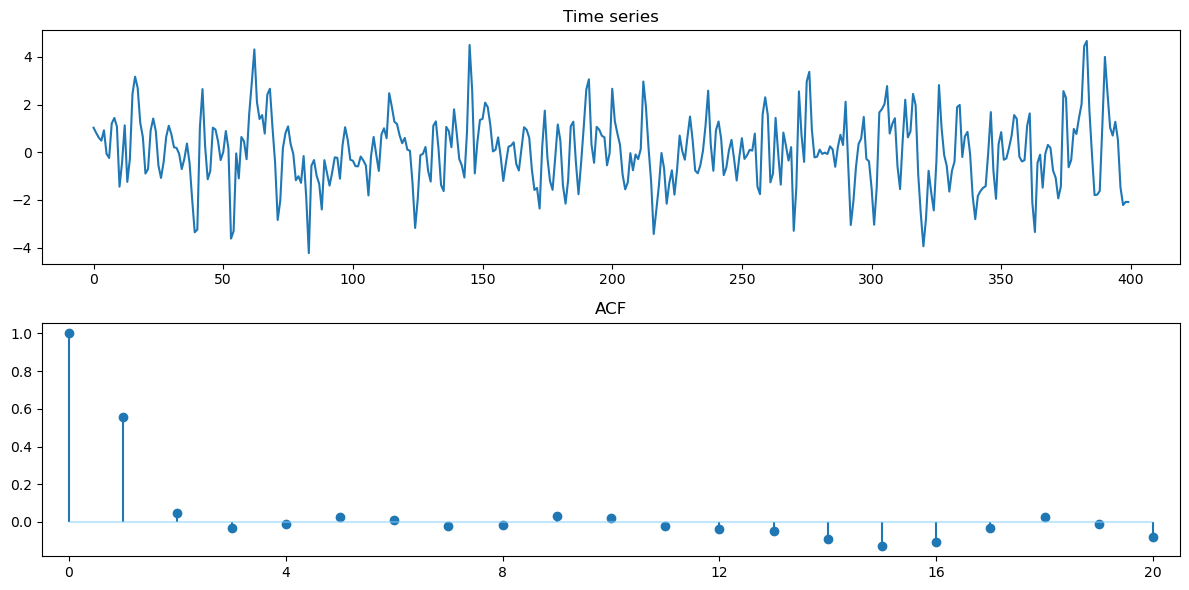

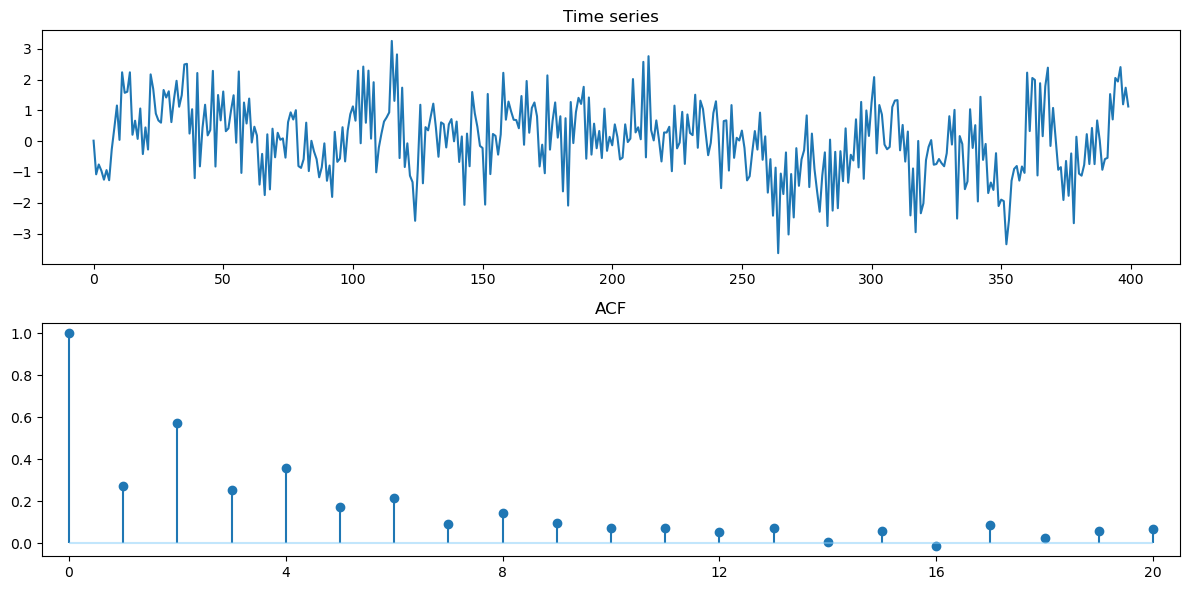

In [2]:
# (2.2.6)

def plot_ts_acf(X, nlags = 20, figsize = (12, 6)):

    fig, axes = plt.subplots(2, 1, figsize = figsize)
    x = range(nlags + 1)
    acf = sm.tsa.acf(X, nlags = nlags)
    titles = ["Time series", "ACF"]

    axes[0].plot(range(len(X)), X)
    axes[1].scatter(x, acf)
    axes[1].vlines(x, 0, acf, color = "tab:blue")
    axes[1].hlines(0, 0, nlags, color = "lightskyblue", alpha  =0.5)
    axes[1].set_xlim(-0.5, nlags + 0.5)
    axes[1].set_xticks([i * 4 for i in range(mth.floor(nlags/4) + 1)])
    for (i, ax) in enumerate(axes):
        ax.set_title(titles[i])
    fig.tight_layout()
    plt.show()

# Only (a) and (b) are causal. 
np.random.seed(457334)

arma = sm.tsa.ArmaProcess(ar = [1.0, -0.1], ma = [1.0, 0.9])
X = arma.generate_sample(nsample = 800)
plot_ts_acf(X[400:])

arma = sm.tsa.ArmaProcess(ar = [1.0, -0.2, -0.5], ma = [1.0])
X = arma.generate_sample(nsample = 800)
plot_ts_acf(X[400:])

In [4]:
# (2.3.7)

# D-L

def DL(acvf, n):
    if len(acvf) <= n:
        raise ValueError("Length of acvf must exceed n")
    
    Lambda = np.zeros((n, n))
    nu = np.zeros(n+1)

    nu[0] = acvf[0]
    Lambda[0, 0] = acvf[1] / acvf[0]
    nu[1] = (1 - Lambda[0,0]**2) * nu[0]

    for i in range(1, n): 
        Lambda[i, i] = (acvf[i+1] - np.dot(Lambda[i - 1, 0:i], acvf[1:(i+1)][::-1]) ) / nu[i]
        nu[i+1] = nu[i] * (1 - Lambda[i,i]**2)
        Lambda[i, 0:i] = Lambda[i-1, 0:i] - Lambda[i,i] * Lambda[i-1, 0:i][::-1]

    return Lambda, nu

# Generate kappa matrix for arma
def kappa_arma(phi, theta, gamma_X):
    n = len(gamma_X)
    q = len(theta)
    p = len(phi)
    m = max(p, q)
    kappa = np.zeros((n, n))
    for i in range(n):
        for j in range(i+1):
            if (i+1 <= m) and (j+1 <= m):
                kappa[i, j] = gamma_X[abs(i-j)]
            elif min(i+1, j+1) <= m < max(i+1, j+1) <= 2*m:
                kappa[i, j] = gamma_X[abs(i-j)]
                for r in range(1, p+1):
                    kappa[i, j] += phi[r-1] * gamma_X[abs(r - abs(i-j))]  # + to keep in accordance with the phi in sm.tsa.ArmaProcess
            elif min(i+1, j+1) > m:
                if i - j == 0:
                    kappa[i, j] = 1.0
                elif abs(i-j) - 1 < q:
                    kappa[i, j] = theta[abs(i-j) - 1]
                for r in range(q):
                    if r + abs(i-j) < q:
                        kappa[i, j] += theta[r] * theta[r + abs(i-j)]
    return kappa + kappa.T - np.diag(np.diag(kappa)) 

# Innovations with kappa matrix

def innov(kappa, n):
    if kappa.shape[0] != kappa.shape[1]:
        raise ValueError("kappa must be a square matrix")

    if kappa.shape[0] <= n:
        raise ValueError("kappa must have dimension at least n")

    Theta = np.zeros((n, n))
    nu = np.zeros(n+1)

    nu[0] = kappa[0, 0]
    Theta[0, 0] = kappa[1, 0] / nu[0]
    nu[1] = kappa[1, 1] - Theta[0,0]**2 * nu[0]

    for i in range(1, n):
        Theta[i, i] = kappa[i + 1, 0] / nu[0]
        for k in range(1, i+1):
            Theta[i, i - k] = (kappa[i + 1, k] - np.sum(Theta[k-1, 0:k] * Theta[i, i-k+1:i+1] * nu[0:k][::-1])) / nu[k]
        nu[i+1] = kappa[i+1,i+1] - np.sum(Theta[i, 0:i+1]**2 * nu[0:i+1][::-1])

    return np.concatenate((np.zeros((1, Theta.shape[1])), Theta), axis = 0), nu

# AR(2)

ar2 = sm.tsa.ArmaProcess(ar = [1.0, -0.4, -0.2])
print(DL(ar2.acf(5), 4))
print("\n")

# MA(1)
ma1 = sm.tsa.ArmaProcess(ma = [1.0, 0.9])
acvf = ma1.acovf(10)
innov(kappa_arma([], [0.9], ma1.acovf(5+1)), 5)

(array([[0.5, 0. , 0. , 0. ],
       [0.4, 0.2, 0. , 0. ],
       [0.4, 0.2, 0. , 0. ],
       [0.4, 0.2, 0. , 0. ]]), array([1.  , 0.75, 0.72, 0.72, 0.72]))




(array([[0.        , 0.        , 0.        , 0.        , 0.        ],
        [0.49723757, 0.        , 0.        , 0.        , 0.        ],
        [0.66055716, 0.        , 0.        , 0.        , 0.        ],
        [0.74043691, 0.        , 0.        , 0.        , 0.        ],
        [0.78698379, 0.        , 0.        , 0.        , 0.        ],
        [0.81690849, 0.        , 0.        , 0.        , 0.        ]]),
 array([1.81      , 1.36248619, 1.21549856, 1.14360678, 1.10171459,
        1.07478236]))

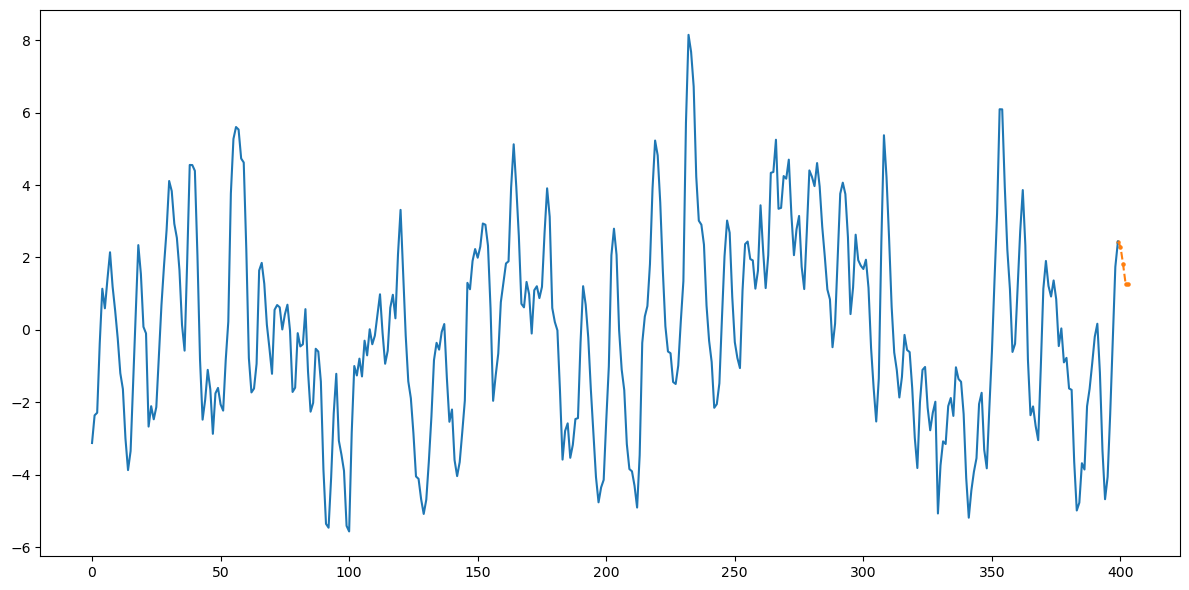

In [333]:
# (2.3.8)
np.random.seed(8453045)

phi = [-1, 0.24]
theta = [0.4, 0.2, 0.1]
p = len(phi)
q = len(theta)
m = max(p, q)

n = 400
burn_in = 400
H = 4

arma = sm.tsa.ArmaProcess(ar = [1.0] + phi, ma = [1.0] + theta)
Xhat = np.zeros(n + H)
Theta, nu = innov(kappa_arma(phi, theta, arma.acovf(n+H+1)), n+H)

X = arma.generate_sample(nsample = n + burn_in)[burn_in:]

for i in range(1, m):
    Xhat[i] = np.dot(Theta[i-1, 0:i][::-1], X[0:i] - Xhat[0:i])

for i in range(m, n+1):
    Xhat[i] = -np.dot(phi[::-1], X[i-p:i]) + np.dot(Theta[i-1, 0:q][::-1], X[i-q:i] - Xhat[i-q:i])

for i in range(1, H):
    # This starts at h=2 due to zero-indexing
    j = p - i 
    if j > 0:
        Xhat[n+i] = -np.dot(phi[::-1][0:j], X[n-j:n]) - np.dot(phi[::-1][j:], Xhat[n:n+(p-j)])
    else:
        Xhat[n+i] = -np.dot(phi[::-1], Xhat[n:n+p])
    Xhat[n + i] += np.dot(Theta[n + i-1, i:q][::-1], X[n+i-q:n] - Xhat[n+i-q:n])


fig, ax = plt.subplots(figsize = (12, 6))
ax.plot(X)
ax.scatter(range(n-1,n+H), np.concatenate((X[n-2:n][1:], Xhat[n:])), color = "tab:orange", s = 5.0)
ax.plot(range(n-1,n+H), np.concatenate((X[n-2:n][1:], Xhat[n:])), color = "tab:orange", linestyle = "--")

fig.tight_layout()
plt.show()

In [7]:
# (2.4.2)

def innov_filter_arma(X, Theta, phi, q):
    p = len(phi)
    m = max(p, q)
    Xhat = np.zeros(n)
    for i in range(1, m):
        Xhat[i] = np.dot(Theta[i, 0:i][::-1], X[0:i] - Xhat[0:i])
    for i in range(m, n):
        Xhat[i] =  -np.dot(phi[::-1], X[i-p:i]) + np.dot(Theta[i, 0:q][::-1], X[i-q:i] - Xhat[i-q:i])
    return X - Xhat

def ll_innov(X, phi, theta, sigma2):
    # phi is  -phi as in sm.tsa.ArmaProcess
    n = len(X)
    p = len(phi) 
    q = len(theta)
    m = max(p, q) 

    acvf = sm.tsa.ArmaProcess(ar = [1.0] + phi, ma = [1.0] + theta).acovf(n+1)
    Theta, r = innov(kappa_arma(phi, theta, acvf), n-1)
    uhat = innov_filter_arma(X, Theta, phi, q)

    return -n/2 * np.log(2*np.pi * sigma2) - 1/2 * np.sum(np.log(r)) - np.sum(uhat**2 / r) / (2 * sigma2)
     
def ll(X, phi, theta, sigma2):
    n = len(X)
    acvf = sigma2 * sm.tsa.ArmaProcess(ar = [1.0] + phi, ma = [1.0] + theta).acovf(n+1)
    Gamma = np.array([[acvf[abs(i-j)] for j in range(n)] for i in range(n)])
    return -n/2 * np.log(2 * np.pi) -1/2 * np.linalg.slogdet(Gamma)[1] -(1/2) * X.T @ np.linalg.solve(Gamma, X)

np.random.seed(452534)

phi  =[-0.4]
theta = [0.2, 0.3]
sigma2 = 3.0
n = 400

X = sm.tsa.ArmaProcess(ar = [1.0] + phi, ma = [1.0] + theta).generate_sample(400, scale = np.sqrt(sigma2))

print(ll_innov(X, phi, theta, sigma2))
print("\n")
print(ll(X, phi, theta, sigma2))

-786.7283398054428


-786.7283398054424


In [93]:
# (2.4.3)

np.random.seed(452534)

phi  =[-0.4]
theta = [0.2, 0.4]
sigma2 = 3.0
n = 400

X = sm.tsa.ArmaProcess(ar = [1.0] + phi, ma = [1.0] + theta).generate_sample(400, scale = np.sqrt(sigma2))

mod = sm.tsa.arima.ARIMA(X, order=(1, 0, 2), trend = "n").fit()
mod.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  400
Model:                 ARIMA(1, 0, 2)   Log Likelihood                -783.979
Date:                Wed, 16 Nov 2022   AIC                           1575.958
Time:                        19:47:15   BIC                           1591.923
Sample:                             0   HQIC                          1582.280
                                - 400                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2935      0.085      3.434      0.001       0.126       0.461
ma.L1          0.3682      0.073      5.043      0.000       0.225       0.511
ma.L2          0.5068      0.057      8.934      0.000       0.396       0.618
sigma2         2.9430      0.210     14.018      0.000       2.532       3.355
===================================================================================
Ljung-Box (Q):                       30.97   Jarque-Bera (JB):                 0.21
Prob(Q):                              0.85   Prob(JB):                         0.90
Heteroskedasticity (H):               0.95   Skew:                            -0.05
Prob(H) (two-sided):                  0.77   Kurtosis:                         3.03
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

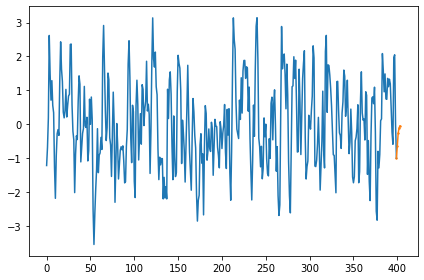

In [158]:
# (2.4.4)
np.random.seed(43526)

phi = [-0.4]
theta = [0.4]
arma = sm.tsa.ArmaProcess([1.0] + phi, [1.0] + theta)
X = arma.generate_sample(400)

mod = sm.tsa.arima.ARIMA(X, order = (1, 0, 1)).fit()
Xhat = mod.forecast(steps = 4)

Y = pd.Series(np.concatenate((X, Xhat)))

fig, ax = plt.subplots()
ax.plot(Y[0:len(X)])
ax.plot(Y[len(X)-1:], color = "tab:orange")
ax.scatter(Y[len(X)-1:].index, Y[len(X)-1:], color = "tab:orange", s = 2)
fig.tight_layout()
plt.show()


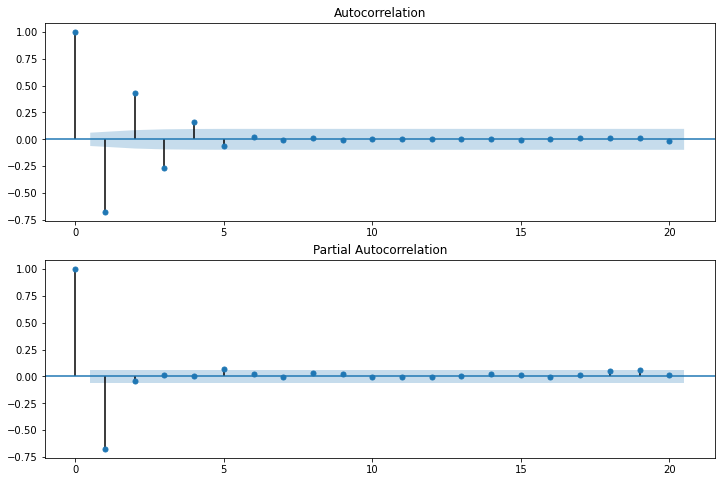

{'bic':              0            1            2
0  3495.556358  3079.551183  2953.962426
1  2900.313682  2905.623879  2912.256755
2  2905.545565  2911.767307  2910.199469, 'bic_min_order': (1, 0)} 



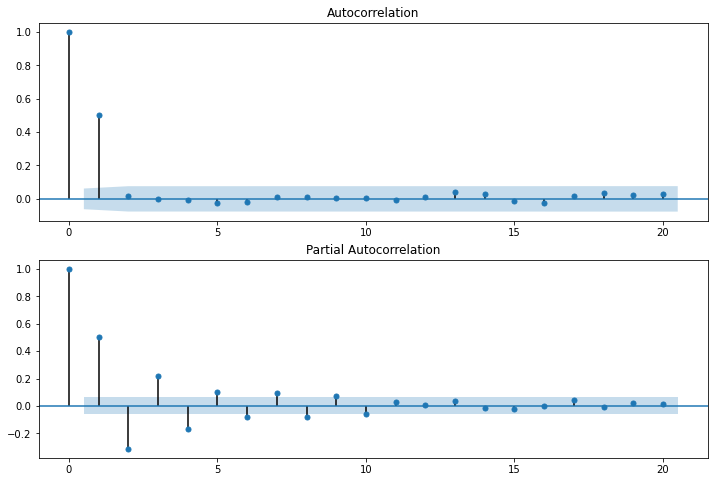

{'bic':              0            1            2
0  3393.593571  2892.900496  2899.647672
1  3111.952930  2899.642438  2906.491261
2  3015.904719  2906.389602  2913.167188, 'bic_min_order': (0, 1)} 



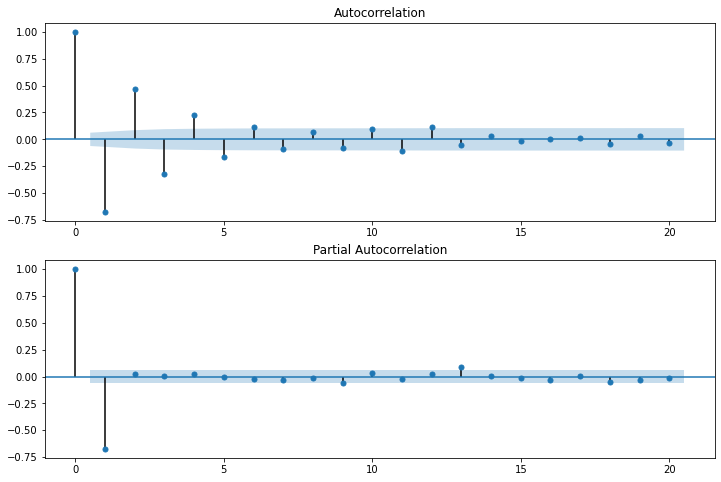

{'bic':              0            1            2
0  3374.729836  2976.179416  2851.676410
1  2777.827661  2784.141302  2790.959237
2  2784.124468  2790.847680  2797.730466, 'bic_min_order': (1, 0)} 



In [178]:
# (2.4.5)

phi = [0.7]
theta = [0.8]
n = 1000

np.random.seed(43526)

ar = sm.tsa.ArmaProcess(ar = [1.0] + phi)
X = ar.generate_sample(n)

fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(X, lags=20, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(X, lags=20, ax=ax2)
plt.show()

ic = sm.tsa.arma_order_select_ic(X, max_ar=2, max_ma=2)
print(ic, "\n")

ma = sm.tsa.ArmaProcess(ma = [1.0] + theta)
X = ma.generate_sample(n)

fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(X, lags=20, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(X, lags=20, ax=ax2)
plt.show()

ic = sm.tsa.arma_order_select_ic(X, max_ar=2, max_ma=2)
print(ic, "\n")


arma = sm.tsa.ArmaProcess(ar = [1.0] + phi, ma = [1.0] + theta)
X = ar.generate_sample(n)

fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(X, lags=20, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(X, lags=20, ax=ax2)
plt.show()

ic = sm.tsa.arma_order_select_ic(X, max_ar=2, max_ma=2)
print(ic, "\n")


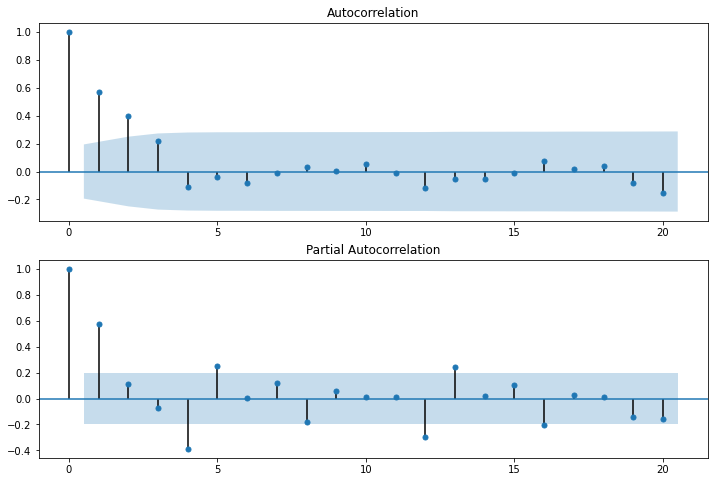

/home/adam/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/adam/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


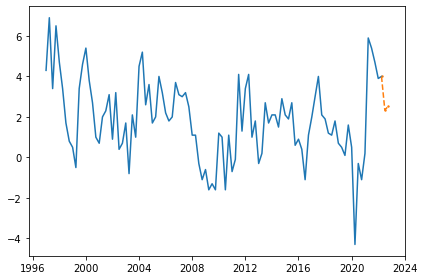

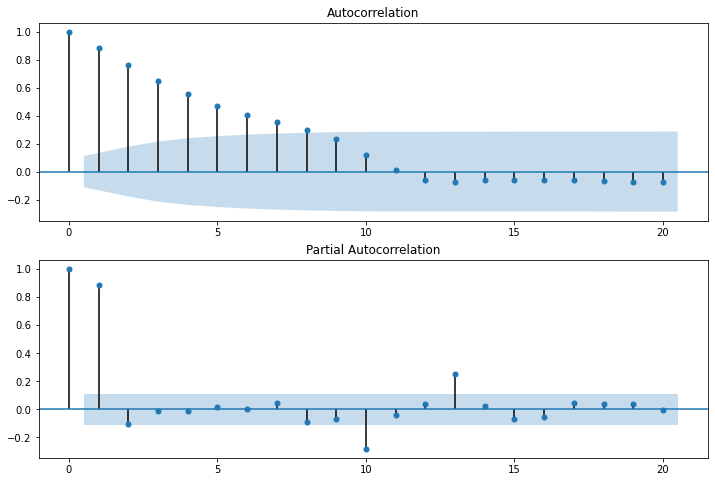

/home/adam/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/adam/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


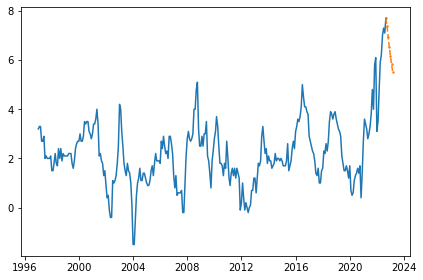

In [98]:
# (2.4.6)

# Quarterly data
qdf = pd.read_csv(
    "https://ec.europa.eu/eurostat/estat-navtree-portlet-prod/BulkDownloadListing?file=data/namq_10_gdp.tsv.gz",
     sep=r'\,|\t',
     engine='python'
).rename(
    columns={'geo\\time':'geo'}
    ).query(
        "s_adj == 'SCA' & geo == 'NO' &  unit == 'CLV_PCH_SM' & na_item == 'B1GQ'"
        ).drop(
            ["s_adj", "na_item", "geo"],
             axis=1
             ).melt(id_vars=['unit']
    ).rename(
        columns = {"variable":"date"}
        ).pivot(
            index = "date",
            columns = "unit",
            values = "value"
            )

qdf.index = pd.PeriodIndex(qdf.index.str.strip(), freq = "Q").to_timestamp()


# Monthly data

mdf =  pd.read_csv("https://ec.europa.eu/eurostat/estat-navtree-portlet-prod/BulkDownloadListing?file=data/prc_hicp_manr.tsv.gz",
                    sep=r'\,|\t',
                    engine='python'
                ).rename(
                    columns={'geo\\time':'geo'}
                    ).query(
                        "coicop == 'CP00' & geo == 'NO'"
                        ).drop(
                            ["unit", "geo"],
                            axis=1
                        ).melt(
                            id_vars= ["coicop"]
                            ).rename(
                                columns = {"variable":"date"}
                                ).pivot(
                            index = "date",
                            columns = "coicop",
                            values = "value"
                            )
mdf.index = pd.PeriodIndex(mdf.index.str.strip().str.replace("M", "-") + "-01", freq = "M").to_timestamp()


qdf_ind = qdf.index >= pd.to_datetime("1997-01-01")
mdf_ind = mdf.index >= pd.to_datetime("1997-01-01")



# GDP
X = qdf[qdf_ind]["CLV_PCH_SM"][:-1].astype(float)

fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(X, lags=20, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(X, lags=20, ax=ax2)
plt.show()

max_ar = 4
max_ma = 4
mods = [(p, q) for p in range(max_ar+1) for q in range(max_ma + 1)]
bic = np.zeros((max_ar+1, max_ma+1))
for p in range(max_ar+1):
    for q in range(max_ma+1):
        bic[p, q] = sm.tsa.arima.ARIMA(X.values, order = (p, 0, q), trend = "c").fit(method_kwargs = {"maxiter": 1000}).bic

# get model with smallest bic
ordr = mods[np.argmin(bic)]
mod = sm.tsa.arima.ARIMA(X.values, order = (ordr[0], 0, ordr[1]), trend="c").fit(method_kwargs = {"maxiter": 1000})
mod.summary()

Xhat = pd.Series(mod.forecast(steps=2))
Xhat.index = pd.to_datetime(["2022-07-01", "2022-10-01"])

fig, ax = plt.subplots()
ax.plot(X)
ax.plot(pd.concat((X.tail(1), Xhat)), color = "tab:orange", linestyle = "--")
ax.scatter(pd.concat((X.tail(1), Xhat)).index, pd.concat((X.tail(1), Xhat)), color = "tab:orange", s=2)
fig.tight_layout()
plt.show()

# Inflation
X = mdf[mdf_ind]["CP00"][:-1].astype(float)


fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(X, lags=20, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(X, lags=20, ax=ax2)
plt.show()


max_ar = 3
max_ma = 2
mods = [(p, q) for p in range(max_ar+1) for q in range(max_ma + 1)]
bic = np.zeros((max_ar+1, max_ma+1))
for p in range(max_ar+1):
    for q in range(max_ma+1):
        bic[p, q] = sm.tsa.arima.ARIMA(X.values, order = (p, 0, q), trend = "c").fit(method_kwargs = {"maxiter": 1000}).bic


# get model with smallest bic
ordr = mods[np.argmin(bic)]

mod = sm.tsa.arima.ARIMA(X.values, order = (ordr[0], 0, ordr[1]), trend="c").fit(method_kwargs = {"maxiter": 1000})
mod.summary()

Xhat = pd.Series(mod.forecast(steps=6))
Xhat.index = pd.to_datetime(["2022-" + x + "-01" for x in ["10", "11", "12"]] + ["2023-" + x + "-01" for x in ["01", "02", "03"]])

fig, ax = plt.subplots()
ax.plot(X)
ax.plot(pd.concat((X.tail(1), Xhat)), color = "tab:orange", linestyle = "--")
ax.scatter(pd.concat((X.tail(1), Xhat)).index, pd.concat((X.tail(1), Xhat)), color = "tab:orange", s=2)
fig.tight_layout()
plt.show()


